#  第十七章 图网络在健康监测中的应用

本章将带您探索构图方法以及图网络在健康监测中的应用实例。我们将学习如何创建自己的图数据，并深入了解图数据与其他类型数据最大的不同之处。在实践中，我们将使用PyTorch和PyG（PyTorch Geometric Library）。PyG是一个基于PyTorch的库，专门用图数据，同时也是一个用于快速实现表征学习的框架。

**Requirments:**

- Python 3
- PyTorch
- PyTorch Geometric

## 17.1 图数据的创建

PyTorch Geometric是一个用于图神经网络的库，它的数据类型包括节点和边。如果要构建图，需要使`torch_geometric.data.Data`类。该类包含了5个属性，但不是所有属性都必须的，可以根据实际需要进行组合：

- `data.x`用于存储每个节点的特征，形状为[num_nodes, num_node_features]；
- `data.edge_index`用于存储节点之间的边，形状为[2, num_edges]；
- `data.pos`用于存储节点的坐标，形状为[num_nodes, num_dimensions]；
- `data.y`用于存储样本标签。如果每个节点都有标签，则形状为[num_nodes, *]；如果整张图只有一个标签，则形状为[1, *]；
- `data.edge_attr`用于存储边的特征，形状为[num_edges, num_edge_features]。

现在，我们来创建一个图数据示例：


In [2]:
import torch
from torch_geometric.data import Data
# 创建节点特征
x = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)
# 创建边索引
edge_index = torch.tensor([[0, 1, 1, 2],                    # 起始点
                           [1, 0, 2, 1]], dtype=torch.long) # 终止点
# 创建节点坐标
pos = torch.tensor([[0, 0], [1, 0], [0, 1]], dtype=torch.float)
# 创建标签
y = torch.tensor([0], dtype=torch.float).view(-1, 1)
# 创建边特征
edge_attr = torch.tensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6], [0.7, 0.8]], dtype=torch.float)
# 创建一张图
data = Data(x=x, edge_index=edge_index, pos=pos, y=y, edge_attr=edge_attr)
# 创建图数据集
dataset=[data]
print(data.y.shape)

torch.Size([1, 1])


上述代码创建了一个包含3个节点和4条边的图数据。每个节点有2个特征，每条边有2个特征。可以根据需要调整节点数量、特征数量以及边的连接关系。

现在看看我们创建的图数据的结构吧。

Dataset:[Data(x=[3, 2], edge_index=[2, 4], edge_attr=[4, 2], y=[1, 1], pos=[3, 2])]:
Number of graphs:1
Number of nodes:3
Number of edges:4


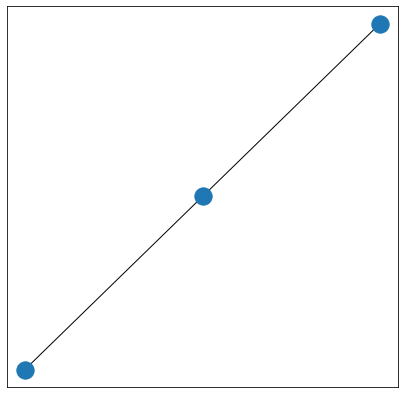

In [3]:
print(f'Dataset:{dataset}:')
print(f'Number of graphs:{len(dataset)}')
print(f'Number of nodes:{data.num_nodes}')
print(f'Number of edges:{data.num_edges}')

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
# 画图函数
def visualize_graph(G):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                      cmap="Set2")
    plt.show()
# 使用networkx进行可视化展示
G = to_networkx(data, to_undirected=True)
visualize_graph(G)

## 17.2 构图方法

在旋转机械健康监测的场景中，将欧几里得结构的时序信号转换为非欧几里得结构的图数据结构十分重要。具体而言，即给本身没有连接关系的时序信号赋予连接关系。目前常用的方法主要分为基于先验知识、基于优化算法和基于统计量的构图方法。

- 基于先验知识的构图方法： 依靠领域专家的经验和先验知识，将时序信号之间的连接关系构建成图结构。这种方法在某些领域中特别有效，因为节点之间的连接关系可以通过相关领域的专业知识来辅助确定。
- 基于统计量的构图方法：这是目前应用最广泛的构图方法之一，它利用时序信号之间的相似性来构建图结构。
- 基于优化算法的构图方法： 该方法使用各种优化算法（例如遗传算法）来寻找最佳的连接方式，以构建图结构。通过优化算法的迭代过程，可以自动学习节点之间的联系。然而，由于计算复杂度较高，这种方法需要大量的计算资源。

本章主要介绍三种基于统计量的构图方法：基于K临近构图，基于余弦相似度构图和基于路径构图。这些方法的目标是根据数据之间的统计量来构建图结构。

### 17.2.1基于K邻近的构图方法

基于K邻近的图构建方法：是一种将数据点之间的相似性转化为图结构的方法。它通过选择一个合适的距离度量方法和计算每个数据点与其他所有数据点之间的距离或相似度，来确定每个数据点的K个最近邻居，并构建一个无向加权图，以此更好地捕捉数据点之间的关系。常用的距离度量有欧氏距离、曼哈顿距离、切比雪夫距离、堪培拉距离等，其中，在旋转机械故障诊断中，欧氏距离是最常用的且表现较好。欧式距离的计算公式如下式所示。
$$
\quad D(x, y)=\sqrt{\left(\sum_{\mu=1}^n\left|x_\mu-y_\mu\right|^2\right)}
$$

基于K邻近的构图方法，每个节点之间的边缘权重可以通过高斯核权重函数来估计，该函数定义为：
$$
e_{i j}=\exp \left(-\frac{\left\|\left(\boldsymbol{x}_i, \boldsymbol{x}_j\right)\right\|^2}{2 \zeta^2}\right), \quad \boldsymbol{x}_j \in \mathrm{Ne}\left(\boldsymbol{x}_i\right)
$$
其中$e_{i j}$表示节点${x}_i$和节点${x}_j$之间的边缘权重。$\zeta$是高斯核的带宽。

In [14]:
import numpy as np
from math import sqrt
from scipy.spatial.distance import pdist

def KNN_classify(k, X_set, x):
    """
    K最近邻分类
    :param k: 邻居的数量
    :param X_set: 数据集
    :param x: 要查找最近邻居的数据点
    :return: node_index, topK_x
    """
    # 计算x与X_set中所有其他点之间的距离
    distances = [sqrt(np.sum((x_compare - x) ** 2)) for x_compare in X_set]
    nearest = np.argsort(distances)              # 找到最近邻居的索引
    node_index = [i for i in nearest[1:k+1]]     # 排除最近的邻居本身
    topK_x = [X_set[i] for i in nearest[1:k+1]]  # 获取最近邻居的坐标
    return node_index, topK_x

def KNN_weigt(x, topK_x):
    """
    计算K最近邻的权重
    :param x: 数据点
    :param topK_x: K个最近邻居的坐标
    :return: w
    """
    distance = []
    v_1 = x
    data_2 = topK_x
    # 计算x与每个邻居之间的距离
    for i in range(len(data_2)):
        v_2 = data_2[i]
        combine = np.vstack([v_1, v_2])
        likely = pdist(combine, 'euclidean')  # 计算了数据集 combine 中各个点之间的欧几里得距离
        distance.append(likely[0])
    # 使用高斯核函数计算权重
    beata = np.mean(distance)
    w = np.exp((-(np.array(distance)) ** 2) / (2 * (beata ** 2)))
    return w

def KNN_attr(data, k):
    '''
    构建K最近邻图
    :param data: 数据集
    :param k: 邻居的数量
    :return: edge_index, edge_fea
    '''
    edge_raw0 = []
    edge_raw1 = []
    edge_fea = []
    # 遍历每个数据点
    for i in range(len(data)):
        x = data[i]
        # 找到最近邻居及其权重
        node_index, topK_x = KNN_classify(k, data, x)
        loal_weigt = KNN_weigt(x, topK_x)
        # 创建本地索引并添加到边的列表中
        local_index = np.zeros(k) + i
        edge_raw0 = np.hstack((edge_raw0, local_index))
        edge_raw1 = np.hstack((edge_raw1, node_index))
        edge_fea = np.hstack((edge_fea, loal_weigt)) # 创建边权重特征
    edge_index = [edge_raw0, edge_raw1]  # 创建边连接关系
    return edge_index, edge_fea

代码中的函数 `KNN_classify` 主要用于执行K最近邻分类，函数 `KNN_weigt` 用于计算K最近邻的权重，函数 `KNN_attr` 用于构建K最近邻图的边索引和特征。

函数 `KNN_classify` 的具体流程如下：

- 首先，计算数据点 `x` 与数据集 `X_set` 中所有其他点之间的距离，并将结果保存在 `distances` 列表中。
- 使用 `np.argsort` 函数找到 `distances` 中距离最近的邻居的索引，并保存在 `nearest` 中。
- 根据参数 `k`，排除最近的邻居本身，将其余的邻居索引保存在 `node_index` 中。
- 获取最近邻居的坐标，将其保存在 `topK_x` 中。
- 最后，返回邻居的索引 `node_index` 和最近邻居的坐标 `topK_x`。

函数 `KNN_weigt` 的具体流程如下：

- 首先，初始化一个空列表 `distance`。
- 获取数据点 `x` 和 K个最近邻居的坐标 `topK_x`。
- 遍历 `topK_x` 中的每个邻居坐标 `v_2`。
- 将数据点 `x` 和邻居坐标 `v_2` 合并为一个矩阵 `combine`。
- 使用 `pdist` 函数计算合并后的矩阵中各个点之间的欧几里得距离，并保存在 `likely` 中。
- 将计算得到的距离添加到 `distance` 列表中。
- 计算平均距离 `beata`。
- 使用高斯核函数计算权重 `w`，其中权重值根据距离计算而来。
- 最后，返回权重 `w`。

函数 `KNN_attr` 的具体流程如下：

- 首先，初始化三个空数组 `edge_raw0`、`edge_raw1` 和 `edge_fea`，用于存储边的索引和特征。
- 遍历数据集 `data` 中的每个数据点 `x`。
- 调用 `KNN_classify` 函数找到最近邻居的索引 `node_index` 和最近邻居的坐标 `topK_x`。
- 调用 `KNN_weigt` 函数计算最近邻的权重 `loal_weigt`。
- 创建本地索引 `local_index`，并将其添加到边的列表 `edge_raw0` 中。
- 将最近邻的索引 `node_index` 添加到边的列表 `edge_raw1` 中。
- 将最近邻的权重 `loal_weigt` 添加到边的列表 `edge_fea` 中。
- 最后，将边的索引 `edge_raw0` 和 `edge_raw1` 合并为一个列表 `edge_index`，并返回边的索引和特征 `edge_index`、`edge_fea`。
### 17.2.2 基于余弦相似度的构图方法

基于余弦相似度的图构建方法与K邻近有一定的相似性，它们都是通过数据点之间的相似性来构建图结构的方法。然而，它们在具体实现上存在一些关键差异。基于余弦相似度的图构建方法使用余弦相似度作为相似性度量标准。该方法首先计算数据点之间的余弦相似度，然后选择相似度最高的K个邻居来构建图结构。当两个节点的特征向量夹角余弦值越大时，表示它们的相似性越高，关联性也更强。两个变量与的余弦相似度计算公式如下式所示。相似度的取值范围在[-1,1]。通过这种方式，可以将相似性转化为图中的连接关系，并利用图算法进行进一步的分析和处理。
$$
\cos (x, y)=\frac{\sum_{i=1}^n x_i y_i}{\sqrt{\sum_{i=1}^n x_i^2} \sqrt{\sum_{i=1}^n y_i^2}}
$$

In [15]:
import numpy as np
from scipy.spatial.distance import pdist
import copy

def cal_sim(data, s1, s2):
    '''
    计算两个样本之间的相似性并生成边的索引和特征
    :param data: 数据集
    :param s1: 样本1的索引
    :param s2: 样本2的索引
    :return: 边索引，边特征
    '''
    edge_index = [[], []]  # 边的索引
    edge_feature = []  # 边的特征
    if s1 != s2:  # 排除自环边
        v_1 = data[s1]  # 获取样本1的特征向量
        v_2 = data[s2]  # 获取样本2的特征向量
        combine = np.vstack([v_1, v_2])  # 将两个特征向量合并为一个矩阵
        likely = 1 - pdist(combine, 'cosine')  # 计算两个样本之间的余弦相似度，使用1减去余弦相似度来得到相似性
        if likely.item() >= 0:  # 如果相似性大于等于0（即两个样本相似），则生成一条边
            w = 1  # 边的权重
            edge_index[0].append(s1)  # 记录边的起始节点
            edge_index[1].append(s2)  # 记录边的结束节点
            edge_feature.append(w)  # 记录边的权重作为特征
    return edge_index, edge_feature

def Radius_attr(data):
    '''
    构建基于半径的图的边索引和特征
    :param data: 数据集
    :return: 边的索引和特征
    '''
    s1 = range(len(data))  # 样本索引范围
    s2 = copy.deepcopy(s1)  # 深拷贝样本索引范围
    edge_index = np.array([[], []])  # 边的索引
    edge_fe = []  # 边的特征
    for i in s1:
        for j in s2:
            local_edge, w = cal_sim(data, i, j)  # 计算两个样本之间的相似性并生成边的索引和权重特征
            edge_index = np.hstack((edge_index, local_edge))  # 将局部边的索引添加到总体边的索引中
            if any(w):  # 如果边的特征不为空
                edge_fe.append(w[0])  # 添加边的特征
    return edge_index, edge_fe

代码中的函数 `cal_sim` 主要用于计算两个样本之间的余弦相似度，并根据余弦相似度生成边的索引和特征。函数 `Radius_attr` 则是构建基于半径的图的边索引和特征。

函数 `cal_sim` 的具体流程如下：

- 首先，根据给定的样本索引 `s1` 和 `s2`，获取对应的样本特征向量 `v_1` 和 `v_2`。
- 将两个特征向量合并为一个矩阵 `combine`。
- 使用余弦相似度度量（1减去余弦相似度），计算两个样本之间的相似性 `likely`。
- 如果相似性大于等于0，则生成一条边，其中边的权重 `w` 设置为1。
- 最后，返回边的索引和特征。

函数 `Radius_attr` 的具体流程如下：

- 首先，定义样本索引范围 `s1` 和 `s2`。
- 初始化边的索引和特征为空数组。
- 遍历所有可能的样本对 `(i, j)`，其中 `i` 为 `s1` 中的索引，`j` 为 `s2` 中的索引。
- 对于每个样本对 `(i, j)`，调用 `cal_sim` 函数计算两个样本之间的相似性并生成边的索引和特征。
- 将局部边的索引添加到总体边的索引中。
- 如果边的特征不为空，则将边的特征添加到总体边的特征中。
- 返回最终的边的索引和特征。
### 17.2.3 基于有向路径图的构图方法

有向路径图是用于描述节点之间有向关系的图形表示方法。在有向路径图中，每个节点代表一个实体或概念，每条有向边表示一种特定的关系。有向路径图通常需要足够的先验知识或者专家经验，以流程图建模法构建图结构，并保持与故障特征的良好对应关系。常用的算法包括最短路径算法、最长路径算法和环检测算法等，可以通过这些算法来解决相关的问题。最简单的有向路径图就是按照时间顺序相连，而边缘权重可以通过高斯核权重函数

$$
e_{i j}=\exp \left(-\frac{\left\|\left(\boldsymbol{x}_i, \boldsymbol{x}_j\right)\right\|^2}{2 \zeta^2}\right), \quad \boldsymbol{x}_j \in \mathrm{Ne}\left(\boldsymbol{x}_i\right)
$$
其中$e_{i j}$表示节点${x}_i$和节点${x}_j$之间的边缘权重。$\zeta$是高斯核的带宽。

In [16]:
import numpy as np
from scipy.spatial.distance import pdist
def Path_attr(data):
    '''
    定义函数 Path_attr，用于计算路径属性。
    参数：data：输入数据
    返回值：edge_index：边索引
    w：权重
    '''
    # 初始化边索引
    edge_index = [[], []]
    # 构建边索引
    for i in range(len(data) - 1):
        edge_index[0].append(i)
        edge_index[1].append(i + 1)
    # 计算相邻节点之间的欧氏距离
    distance = []
    for j in range(len(data) - 1):
        v_1 = data[j]
        v_2 = data[j + 1]
        combine = np.vstack([v_1, v_2])
        likely = pdist(combine, 'euclidean')
        distance.append(likely[0])
    # 计算高斯核权重
    beata = np.mean(distance)
    w = np.exp((-(np.array(distance)) ** 2) / (2 * (beata ** 2)))  #Gussion kernel高斯核
    return edge_index, w

代码中函数 `Path_attr` ，用于计算路径属性。该函数接受一个参数 `data`，表示输入的数据。

该函数主要实现以下功能：

1. 初始化边索引 `edge_index`，用于表示节点之间的连接关系。
2. 根据输入的数据计算相邻节点间的欧氏距离，保存在列表 `distance` 中。
3. 根据计算得到的欧氏距离和高斯核公式计算权重，并将结果保存在变量 `w` 里。
4. 返回两个值，分别是边索引 `edge_index` 和权重 `w`。

## 17.3 故障诊断中的图网络应用案例

故障诊断是通过检测、分析和判断，识别出设备或系统中出现的故障，并提供相应的解决方案或建议的过程。在现代工业生产中，故障诊断至关重要，它能够显著提高设备运行效率，减少生产线停机时间，从而降低生产成本。随着图网络的发展，其在故障诊断领域的应用日益受到重视，本章将深入探讨如何利用图网络构建一个基础的旋转机械故障诊断应用案例。从数据出发，通过分析和预测，实现旋转机械健康状态的故障诊断。

在实际的工业环境中，由于大量的传感器被用于监测系统状态，因此故障诊断领域的数据集十分丰富。为更好地适应这些数据的特点并提高模型的准确性，本章将采用图级分类任务。

### 17.3.1 数据集简介

凯斯西储大学的轴承数据集（Case Western Reserve University Bearing Data Set）是一个公开的机器学习与故障诊断研究数据集。此数据集由凯斯西储大学的机械工程系与轴承制造商联手创建，旨在为轴承故障诊断算法的研究与开发提供一个标准化的数据集。该数据集涵盖了各种不同故障模式与工作条件下的轴承振动数据。

<img src="../../figures/17健康监测/凯斯西储大学轴承试验台.png" style="zoom:60%;" />

数据集的原始链接为[此处](https://engineering.case.edu/bearingdatacenter/welcome)。这个数据集主要涉及旋转机械系统中轴承的振动信号数据。轴承在旋转机械中扮演着关键角色，通常在高速、高负荷的环境下运作，因此容易发生故障。这些故障可能是由轴承内部的各种缺陷引起，如加工或组装过程中的形变。外部环境因素也可能导致各种故障，如变形、磨损或裂纹。通过监测轴承的振动信号，我们可以获取轴承运行状态的信息，进而进行故障诊断和预测。

为了方便赘述，对原始数据集进行了重构，[链接地址](https://pan.baidu.com/s/1IoyQQB_8zuPDD2IP-ILb5g )，提取码：xcdx

其中CRWU凯斯西储大学轴承数据下，包含4个文件夹

![数据集路径](../../figures/17健康监测/数据集路径.png)

分别表示**12k 驱动端轴承故障数据，12k风扇端轴承故障数据,48k 驱动端轴承故障数据，正常基线数据**

前三个文件夹主要包括三个子文件夹,分别代表三种故障部位，Ball：滚珠圈的振动数据；Inner Race：内圈的振动数据；Outer Race：外圈的振动数据；

![子目录数据集路径](../../figures/17健康监测/子目录数据集路径.png)

每个故障部位的子文件夹包括多个故障直径，通常用来描述故障的大小和程度，单位为英寸，1英寸=25.4mm

- 0.007英寸=7 mils =0.1778 mm
- 0.014英寸=14 mils =0.3556 mm
- 0.021英寸=21 mils =0.5334 mm
- 0.028英寸=28 mils =1.016 mm

![故障程度](../../figures/17健康监测/故障程度.png)

每个故障等级下，根据不同的电机负载情况，划分了0/1/2/3等多种负载情况下的数据。

![故障负载](../../figures/17健康监测/故障负载.png)

### 17.3.2 数据预处理

由于Matlab具有高效的数据处理能力，并且可以处理原始的.m文件格式，因此我们将使用Matlab来处理数据集。

~~~matlab
%============Arrange data ===========%
% 1、清除
clear;    % 从工作区中删除项目，释放系统内存  
clc;      % 清理命令窗口
close all % 移除指定绘画
% 2、保存路径
savepath = 'D:\file_folder\联邦图网络\code\data\CWRU\'; %这是原始数据地址，需要从度盘下载后更改
% 3、数据来源路径
Datapath='D:\file_folder\联邦图网络\code\data\CWRU\'; %这是保存地址，需要读者自行更改
% %=====Label-1 Data----负载L0=====%%
% 4、加载数据--负载L0
a1=load([Datapath,'B007.mat']);  % 故障模式B007
a2=load([Datapath,'B014.mat']);  % 故障模式B014
a3=load([Datapath,'B021.mat']);  % 故障模式B021
b1=load([Datapath,'IR007.mat']); % 故障模式IR007
b2=load([Datapath,'IR014.mat']); % 故障模式IR014
b3=load([Datapath,'IR021.mat']); % 故障模式IR021
c1=load([Datapath,'OR007_6.mat']); % 故障模式OR007_6
c2=load([Datapath,'OR014_6.mat']); % 故障模式OR014_6
c3=load([Datapath,'OR021_6.mat']); % 故障模式OR021_6
d1=load([Datapath,'Normal.mat']); % 正常运行状态
% 5、数据切片
L=512;
for i=1:450
    Data0(i,:) = d1.X099_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data1(i,:) = a1.X107_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data2(i,:) = a2.X187_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data3(i,:) = a3.X224_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data4(i,:) = b1.X120_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data5(i,:) = b2.X171_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data6(i,:) = b3.X211_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data7(i,:) = c1.X132_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data8(i,:) = c2.X199_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
    Data9(i,:) = c3.X236_DE_time((L-250)*(i-1)+1:L*i-250*(i-1),1);
end
% 6、标签设定
Data0(:,513)=0;
Data1(:,513)=1;
Data2(:,513)=2;
Data3(:,513)=3;
Data4(:,513)=4;
Data5(:,513)=5;
Data6(:,513)=6;
Data7(:,513)=7;
Data8(:,513)=8;
Data9(:,513)=9;
% 7、整合数据
Data = [Data0;Data1;Data2;Data3;Data4;Data5;Data6;Data7;Data8;Data9];
% 8、保存文件
savepath1=[savepath,'L1750.mat']
save(savepath1,'Data')
~~~
### 17.3.3 构造图级别图数据

数据整合结束后，我们将采用上述构图方法去构造图数据。


In [33]:
from torch_geometric.data import Data  # 导入Data模块，用于构造图数据
from scipy.io import loadmat  # 导入loadmat函数，用于加载.mat文件
import torch  # 导入torch模块，用于张量操作和构造数据集
from sklearn.model_selection import train_test_split  # 导入train_test_split函数，用于划分训练集和测试集
import numpy as np  # 导入numpy模块，用于构造数据集
from math import sqrt # 导入sqrt模块，用于构造图数据集
from scipy.spatial.distance import pdist # 计算数据集各个点之间的欧几里得距离

def KNN_classify(k, X_set, x):
    """
    K最近邻分类
    :param k: 邻居的数量
    :param X_set: 数据集
    :param x: 要查找最近邻居的数据点
    :return: node_index, topK_x
    """
    # 计算x与X_set中所有其他点之间的距离
    distances = [sqrt(np.sum((x_compare - x) ** 2)) for x_compare in X_set]
    nearest = np.argsort(distances)              # 找到最近邻居的索引
    node_index = [i for i in nearest[1:k+1]]     # 排除最近的邻居本身
    topK_x = [X_set[i] for i in nearest[1:k+1]]  # 获取最近邻居的坐标
    return node_index, topK_x

def KNN_weigt(x, topK_x):
    """
    计算K最近邻的权重
    :param x: 数据点
    :param topK_x: K个最近邻居的坐标
    :return: w
    """
    distance = []
    v_1 = x
    data_2 = topK_x
    # 计算x与每个邻居之间的距离
    for i in range(len(data_2)):
        v_2 = data_2[i]
        combine = np.vstack([v_1, v_2])
        likely = pdist(combine, 'euclidean')  # 计算数据集 combine 中各个点之间的欧几里得距离
        distance.append(likely[0])
    # 使用高斯核函数计算权重
    beata = np.mean(distance)
    w = np.exp((-(np.array(distance)) ** 2) / (2 * (beata ** 2)))
    return w

def KNN_attr(data, k):
    '''
    构建K最近邻图
    :param data: 数据集
    :param k: 邻居的数量
    :return: edge_index, edge_fea
    '''
    edge_raw0 = []
    edge_raw1 = []
    edge_fea = []
    # 遍历每个数据点
    for i in range(len(data)):
        x = data[i]
        # 找到最近邻居及其权重
        node_index, topK_x = KNN_classify(k, data, x)
        loal_weigt = KNN_weigt(x, topK_x)
        # 创建本地索引并添加到边的列表中
        local_index = np.zeros(k) + i
        edge_raw0 = np.hstack((edge_raw0, local_index))
        edge_raw1 = np.hstack((edge_raw1, node_index))
        edge_fea = np.hstack((edge_fea, loal_weigt)) # 创建边权重特征
    edge_index = [edge_raw0, edge_raw1]  # 创建边连接关系
    return edge_index, edge_fea

def data_graph(dir):
    """
    构造图数据
    :param dir: 路径
    :return: train_dataset, test_dataset
    """
    m2 = loadmat(dir + "L1750.mat")  # 加载L1750.mat文件到变量m2
    s = m2["Data"]  # 从m2中获取名为"Data_1"的变量，赋值给s
    x = s[:, 0:512]  # 提取s的前512列作为特征x
    y = s[:, 512]  # 提取s的第512列作为标签y
    data_x = []  # 用于存储数据的列表
    label_y = []  # 用于存储标签的列表
    Edge_index = []  # 用于存储边索引的列表
    dataset = []  # 用于存储最终的数据集的列表
    
    # 循环处理数据，每10行为一组
    for i in range(x.shape[0] // 10):
        data_x.append(x[i * 10:i * 10 + 10, :])  # 将特征x的每10行作为一个数据点，添加到data_x中
        label_y.append(int(y[i * 10]))  # 将标签y的每10行的第一个元素添加到label中
        edge_index, edge_fea = KNN_attr(data_x[i],3)  # 调用KNN_attr函数计算边索引和边特征
        Edge_index.append(edge_index)  # 将边索引添加到Edge_index中
    
    data_x = torch.tensor(np.array(data_x), dtype=torch.float)  # 将data_x转换为torch张量
    label_y = torch.tensor(np.array(label_y), dtype=torch.long)  # 将label转换为torch张量
    Edge_index = torch.tensor(np.array(Edge_index), dtype=torch.int64)  # 将Edge_index转换为torch张量
    
    # 循环创建Data对象，并添加到dataset中
    for i in range(x.shape[0] // 10):
        data = Data(x=data_x[i], y=label_y[i], edge_index=Edge_index[i])  # 创建Data对象，包含特征x、标签y和边索引edge_index
        dataset.append(data)  # 将data添加到dataset中
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=0)  # 划分训练集和测试集
    
    return train_dataset, test_dataset  # 返回训练集和测试集

if __name__ == '__main__':
    # 获取数据集
    dir=r".\CWRU\\"
    train_dataset, test_dataset=data_graph(dir)

### 17.3.4 图数据可视化
为了更进一步看到生成的图数据，本章将进行可视化操作，清晰看到生成的图数据

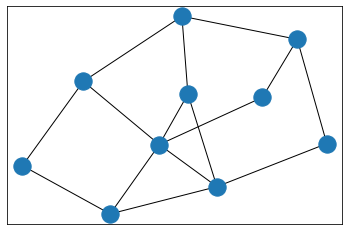

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
# 画图函数
def visualize_graph(G):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                      cmap="Set2")
    plt.show()
# 使用networkx进行可视化展示
G = to_networkx(train_dataset[0], to_undirected=True)
visualize_graph(G)

### 17.3.5 构造图网络

图数据构造结束之后，接下来，我们构造图网络，采用PyTorch Geometric的GCNConv层构建

In [35]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.nn as pyg_nn
import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        torch.manual_seed(520)
        self.conv1 = GCNConv(512, 300)  # 第一个图卷积层，输入特征维度为512，输出特征维度为300
        self.conv2 = GCNConv(300, 200)  # 第二个图卷积层，输入特征维度为300，输出特征维度为200
        self.fc1 = nn.Linear(200, 100)  # 全连接层，输入特征维度为200，输出特征维度为100
        self.fc2 = nn.Sequential(nn.Linear(100,50), nn.GELU(),nn.Linear(50,25), nn.GELU(),nn.Linear(25,10)) # 多层全连接层
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) # Dropout层，防止过拟合
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = pyg_nn.global_max_pool(x, batch) # 全局最大池化
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # 输出层使用log_softmax进行分类

### 17.3.6 模型训练与预测

图数据构造结束之后，接下来，我们将利用图网络进行数据分析和预测。通过对图网络的深入挖掘，我们可以发现数据中的异常模式和趋势，进而利用图网络进行故障诊断，代码如下：

In [36]:
from torch_geometric.data import Data  # 导入Data模块，用于构造图数据
from scipy.io import loadmat  # 导入loadmat函数，用于加载.mat文件
import torch  # 导入torch模块，用于张量操作和构造数据集
from sklearn.model_selection import train_test_split  # 导入train_test_split函数，用于划分训练集和测试集
import numpy as np 
from math import sqrt  
from scipy.spatial.distance import pdist 
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric.nn as pyg_nn

# 定义K最近邻分类函数
def KNN_classify(k, X_set, x):
    """
    K最近邻分类
    :param k: 邻居的数量
    :param X_set: 数据集
    :param x: 要查找最近邻居的数据点
    :return: node_index, topK_x
    """
    # 计算x与X_set中所有其他点之间的距离
    distances = [sqrt(np.sum((x_compare - x) ** 2)) for x_compare in X_set]
    nearest = np.argsort(distances)  # 找到最近邻居的索引
    node_index = [i for i in nearest[1:k + 1]]  # 排除最近的邻居本身
    topK_x = [X_set[i] for i in nearest[1:k + 1]]  # 获取最近邻居的坐标
    return node_index, topK_x

# 定义计算K最近邻权重函数
def KNN_weigt(x, topK_x):
    """
    计算K最近邻的权重
    :param x: 数据点
    :param topK_x: K个最近邻居的坐标
    :return: w
    """
    distance = []
    v_1 = x
    data_2 = topK_x
    # 计算x与每个邻居之间的距离
    for i in range(len(data_2)):
        v_2 = data_2[i]
        combine = np.vstack([v_1, v_2])
        likely = pdist(combine, 'euclidean')  # 计算数据集 combine 中各个点之间的欧几里得距离
        distance.append(likely[0])
    # 使用高斯核函数计算权重
    beata = np.mean(distance)
    w = np.exp((-(np.array(distance)) ** 2) / (2 * (beata ** 2)))
    return w

# 定义构建K最近邻图函数
def KNN_attr(data, k):
    '''
    构建K最近邻图
    :param data: 数据集
    :param k: 邻居的数量
    :return: edge_index, edge_fea
    '''
    edge_raw0 = []
    edge_raw1 = []
    edge_fea = []
    # 遍历每个数据点
    for i in range(len(data)):
        x = data[i]
        # 找到最近邻居及其权重
        node_index, topK_x = KNN_classify(k, data, x)
        loal_weigt = KNN_weigt(x, topK_x)
        # 创建本地索引并添加到边的列表中
        local_index = np.zeros(k) + i
        edge_raw0 = np.hstack((edge_raw0, local_index))
        edge_raw1 = np.hstack((edge_raw1, node_index))
        edge_fea = np.hstack((edge_fea, loal_weigt))  # 创建边权重特征
    edge_index = [edge_raw0, edge_raw1]  # 创建边连接关系
    return edge_index, edge_fea

# 定义构造图数据函数
def data_graph(dir):
    """
    构造图数据
    :param dir: 路径
    :return: train_dataset, test_dataset
    """
    m2 = loadmat(dir + "L1750.mat")  # 加载L1750.mat文件到变量m2
    s = m2["Data"]  # 从m2中获取名为"Data_1"的变量，赋值给s
    x = s[:, 0:512]  # 提取s的前512列作为特征x
    y = s[:, 512]  # 提取s的第512列作为标签y
    data_x = []  # 用于存储数据的列表
    label_y = []  # 用于存储标签的列表
    Edge_index = []  # 用于存储边索引的列表
    dataset = []  # 用于存储最终的数据集的列表

    # 循环处理数据，每10行为一组
    for i in range(x.shape[0] // 10):
        data_x.append(x[i * 10:i * 10 + 10, :])  # 将特征x的每10行作为一个数据点，添加到data_x中
        label_y.append(int(y[i * 10]))  # 将标签y的每10行的第一个元素添加到label中
        edge_index, edge_fea = KNN_attr(data_x[i], 3)  # 调用KNN_attr函数计算边索引和边特征
        Edge_index.append(edge_index)  # 将边索引添加到Edge_index中

    data_x = torch.tensor(np.array(data_x), dtype=torch.float)  # 将data_x转换为torch张量
    label_y = torch.tensor(np.array(label_y), dtype=torch.long)  # 将label转换为torch张量
    Edge_index = torch.tensor(np.array(Edge_index), dtype=torch.int64)  # 将Edge_index转换为torch张量

    # 循环创建Data对象，并添加到dataset中
    for i in range(x.shape[0] // 10):
        data = Data(x=data_x[i], y=label_y[i], edge_index=Edge_index[i])  # 创建Data对象，包含特征x、标签y和边索引edge_index
        dataset.append(data)  # 将data添加到dataset中

    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=0)  # 划分训练集和测试集

    return train_dataset, test_dataset  # 返回训练集和测试集

# 定义GCN模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        torch.manual_seed(520)
        self.conv1 = GCNConv(512, 300)  # 第一个图卷积层，输入特征维度为512，输出特征维度为300
        self.conv2 = GCNConv(300, 200)  # 第二个图卷积层，输入特征维度为300，输出特征维度为200
        self.fc1 = nn.Linear(200, 100)  # 全连接层，输入特征维度为200，输出特征维度为100
        self.fc2 = nn.Sequential(nn.Linear(100,50), nn.GELU(),nn.Linear(50,25), nn.GELU(),nn.Linear(25,10)) # 多层全连接层
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) # Dropout层，防止过拟合
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = pyg_nn.global_max_pool(x, batch) # 全局最大池化
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # 输出层使用log_softmax进行分类
    
# 定义训练函数
def train(train_loader, train_dataset):
    """
    训练模型
    :param train_loader: 训练数据加载器
    :param train_dataset: 训练数据集
    :return: 平均损失值 (loss_all / len(train_dataset))
    """
    model.train()  # 设置模型为训练模式
    loss_all = 0  # 初始化总损失为0
    for data in train_loader:  # 遍历训练数据集
        data = data.to(device)  # 将数据移动到指定设备（如GPU）
        optimizer.zero_grad()  # 清零优化器的梯度
        output = model(data)  # 运行模型获取输出
        label = data.y.to(device)  # 获取标签并移动到指定设备
        loss = criterion(output, label)  # 计算损失
        loss.backward()  # 反向传播计算梯度
        loss_all += loss.item()  # 累加损失
        optimizer.step()  # 根据梯度更新模型参数
    return (loss_all / len(train_dataset))  # 返回平均损失值

# 定义测试函数
def evaluate(test_loader, test_dataset):
    """
    评估模型
    :param test_loader: 测试数据加载器
    :param test_dataset: 测试数据集
    :return: 准确率
    """
    model.eval()  # 设置模型为评估模式
    correct = 0  # 初始化正确预测数量为0
    with torch.no_grad():  # 禁用梯度计算
        for data in test_loader:  # 遍历测试数据集
            data = data.to(device)  # 将数据移动到指定设备（如GPU）
            out = model(data)  # 获取模型输出
            pred = out.argmax(dim=1)  # 获取预测标签
            correct += pred.eq(data.y).sum().item()  # 统计正确预测数量
        accuracy = correct / len(test_dataset)  # 计算准确率
    return accuracy  # 返回准确率

if __name__ == '__main__':
    # 1.获取数据集
    dir = r".\CWRU\\"
    train_dataset, test_dataset = data_graph(dir)  # 获取训练集和测试集
    train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)  # 创建训练数据加载器
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)  # 创建测试数据加载器
    # 2.模型建立
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设置设备（GPU或CPU）
    model = Net().to(device)  # 创建模型并将其移动到指定设备上
    criterion = torch.nn.NLLLoss()  # 定义损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-5, betas=(0.9, 0.99))  # 定义优化器
    # 3.迭代训练
    for epoch in range(50):  # 迭代训练
        loss = train(train_loader, train_dataset)  # 训练模型并获取平均损失值
        if epoch % 10 == 0:  # 每10个epoch输出一次训练信息
            acc = evaluate(test_loader, test_dataset)  # 测试模型并获取准确率
            print("Epoch:%d|train loss:%.4f|test accuracy:%.4f" % (epoch, loss, acc))  # 输出结果信息

Epoch:0|train loss:0.0960|test accuracy:0.0889
Epoch:10|train loss:0.0872|test accuracy:0.1111
Epoch:20|train loss:0.0818|test accuracy:0.1889
Epoch:30|train loss:0.0754|test accuracy:0.2444
Epoch:40|train loss:0.0673|test accuracy:0.3556


## 17.4 寿命预测中的图网络应用案例

寿命预测是一种基于设备或系统的历史数据和运行状态，利用模型对其未来寿命或剩余寿命进行预测的技术。这种预测可以帮助企业制定更为精准的设备维护计划，提前预防可能出现的故障，降低维修成本，延长设备使用寿命，提高生产效率。随着工业设备日益复杂化，对设备寿命预测的准确性要求也越来越高。图网络作为一种强大的数据处理工具，在寿命预测领域的应用也日益受到关注。在本章中，我们将深入探讨如何利用图网络构建一个基础的旋转机械寿命预测应用案例。通过这一应用案例，我们将从实际数据出发，利用图网络进行数据分析和预测，从而实现旋转机械健康状态的寿命预测。

在实际的工业环境中，由于全寿命数据的获取条件极为严格，因此全寿命的数据集十分稀缺。为了更好地适应这些数据的特性并提高模型的准确性，本章将采用节点级分类任务。

### 17.4.1 数据集简介

IEEE PHM 2012 数据挑战赛有IEEE 可靠性协会和 FEMTO-ST 研究所组织，该挑战赛提供了**轴承的剩余寿命预测**的数据集，实验平台如下：

<img src="../../figures/17健康监测/IEEE PHM 2012挑战赛.png" style="zoom:80%;" />

[数据集获取](https://github.com/wkzs111/phm-ieee-2012-data-challenge-dataset)，有三种工况，具体训练集和测试集特征如下所示：

①：负载4000N，转速1800rpm;

②：负载4200N，转速1650rpm;

③：负载5000N，转速1500rpm；

<img src="../../figures/17健康监测/phn2012数据集.png" alt="phm2012" style="zoom:70%;" />

振动文件为acc_xxxxx.csv，温度文件为temp_xxxxx.csv

**振动信号(水平方向和垂直方向)：**

1.采样频率：25.6KHz；
2.采集设置：10秒采集一次，一次采集0.1s，即一次采集2560个点；示意图如下 温度信号 采样频率：10Hz;采集设置：每分钟采集600点

**每个文件的列标签：**

![数据解释](../../figures/17健康监测/iee2012数据解释.png)

**温度信号：**

1.采样频率：10Hz;

2.采集设置：每分钟采集600点；

**注意：该数据为比赛数据，所有存放数据的文件夹有三个，一个是训练数据(Learning_set)，一个是比赛时采用的截断数据(Test_set)，一个是全寿命数据(Full_Test_set)，这个Full_Test_set是Test_set的完整版。**

### 17.4.2 数据预处理

由于Matlab具有高效的数据处理能力，并且可以处理原始的.m文件格式，因此我们将使用Matlab来处理数据集，考虑到荷载是在水平方向上施加的情况，故选择了水平振动信号来反映轴承退化信息。
~~~matlab
%% 批量读取IEEE PHM 2012轴承全寿命数据
clc
clear all
close all
%% 1、设置文件路径
file_path =  'G:\联邦图网络\code\data\phm2012\原始数据\phm-ieee-2012-data-challenge-dataset\Full_Test_Set\Bearing1_5\'; % 文件夹路径
savepath = 'G:\联邦图网络\code\data\phm2012\带标签特征\';
%% 2、整合全寿命水平振动加速度信号
csv_acc_path_list = dir(strcat(file_path,'acc*.csv')); % 获取该文件夹中所有csv格式的文件
csv_acc_num = length(csv_acc_path_list); % 获取文件总数量
if csv_acc_num > 0 % 有满足条件的文件
    for j = 1:csv_acc_num % 逐一读取文件
        csv_acc_name = csv_acc_path_list(j).name; % 文件名
        csv_acc =  csvread(strcat(file_path,csv_acc_name)); % 读取csv文件中的数据
        csv_acc_data(:,j)=csv_acc(:,5); % 存储读取的数据水平加速度信号到csv_acc_data变量中
        fprintf('%d %d %s\n',csv_acc_num,j,strcat(file_path,csv_acc_name)); % 显示正在处理的文件名
    end
end
%% 3、全寿命振动信号的时域图
csv_temp_data=reshape(csv_acc_data,1,prod(size(csv_acc_data)))'; % 重塑矩阵形状
figure;
plot(csv_temp_data);title('水平振动信号')
%% 4、数据特征提取
[~, cols] = size(csv_acc_data);%获取数据形状
Time=1:cols;%时间戳
Max=max(csv_acc_data);%1.最大值
Min=min(csv_acc_data);%2.最小值
Peak=max(abs(csv_acc_data)); %3.峰值
P2p=max(csv_acc_data)-min(csv_acc_data);%4.峰峰值
Mean=mean(csv_acc_data);%5.均值
AverageAmplitude=mean(abs(csv_acc_data));%6.绝对平均值（平均幅值）
RootAmplitude=mean(sqrt(abs(csv_acc_data))).^2;%7.方根幅值
Var=var(csv_acc_data,1);%8.方差  有偏
Std=std(csv_acc_data,1);%9.标准差
Rms=sqrt(sum(csv_acc_data.^2)./length(csv_acc_data));%10.有效值（均方根）
Kurtosis=kurtosis(csv_acc_data,1);%11.峭度
Skewness=skewness(csv_acc_data,1);%12.偏度
ShapeFactor=Rms./AverageAmplitude;%13.波形因子
PeakingFactor=Peak./Rms;%14.峰值因子（波峰因子）
PulseFactor=Peak./AverageAmplitude;%15.脉冲因子
MarginFactor=Peak./RootAmplitude;%16.裕度因子
ClearanceFactor=Peak./Rms.^2;%17.余隙因子
feature_RUL=[Time;Max;Min;Peak;P2p;Mean;AverageAmplitude;RootAmplitude;Var;Std;Rms;Kurtosis;Skewness;ShapeFactor;PeakingFactor;PulseFactor;MarginFactor;ClearanceFactor]; %垂直拼接
feature_RUL=permute(feature_RUL,[2 1]); % 调整维度顺序
%% 5、变点检测并建立剩余寿命标签
changePoints = findchangepts(Rms);%寻找变点
labels = [ones(changePoints-1, 1); linspace(1, 0, cols-changePoints+1)']; % 生成标签
[~, cols1] = size(feature_RUL);%获取数据形状
feature_RUL(:,19)=labels; %增添标签
%% 6、保存文件
savepath1=[savepath,'负载4000_5_5.mat']
save(savepath1,'feature_RUL')
~~~

### 17.4.3 构造节点级图数据

处理后的[数据集链接](https://pan.baidu.com/s/13V-hY1qQVtSlQz0_1Cgsgg )，提取码：phm2，分为带标签时域和带标签特征两个文件夹，每个文件又包括如下：

![带标签特征](../../figures/17健康监测/phm2012数据.png)

本章使用带标签特征数据，妙地利用数据本身所蕴含的时序关系，将相邻时刻的信号进行有机连接，进而生成具有丰富信息的时序路径图。在这种图结构中，每个节点都代表着特定的时序信号，而节点的特征则是从原始的时序数据中精心筛选的时域统计指标，如图所示：

<img src="../../figures/17健康监测/时域指标.png" style="zoom:100%;" />

In [37]:
from torch_geometric.data import Data  # 导入Data模块，用于构造图数据
from scipy.io import loadmat  # 导入loadmat函数，用于加载.mat文件
import torch  # 导入torch模块，用于张量操作和构造数据集
import numpy as np  # 导入numpy模块，用于构造数据集
from scipy.spatial.distance import pdist # 计算数据集各个点之间的欧几里得距离

def Path_attr(data):
    '''
    定义函数 Path_attr，用于计算路径属性。
    参数：data：输入数据
    返回值：edge_index：边索引
    w：权重
    '''
    # 初始化边索引
    edge_index = [[], []]
    # 构建边索引
    for i in range(len(data) - 1):
        edge_index[0].append(i)
        edge_index[1].append(i + 1)
    # 计算相邻节点之间的欧氏距离
    distance = []
    for j in range(len(data) - 1):
        v_1 = data[j]
        v_2 = data[j + 1]
        combine = np.vstack([v_1, v_2])
        likely = pdist(combine, 'euclidean')
        distance.append(likely[0])
    # 计算高斯核权重
    beata = np.mean(distance)
    w = np.exp((-(np.array(distance)) ** 2) / (2 * (beata ** 2)))  #Gussion kernel高斯核
    return edge_index, w

def data_graph(dir):
    """
    构造图数据
    :param dir: 路径
    :return: train1_dataset, train2_dataset, train3_dataset, train4_dataset, test_dataset
    """
    # 加载训练数据1
    m1 = loadmat(dir + "负载4000_1_5.mat")
    train_s1 = m1["feature_RUL_time"]
    train_x1 = train_s1[:, 0:18]  # 左闭右开
    train_y1 = train_s1[:, 18]
    # 加载训练数据2
    m2 = loadmat(dir + "负载4000_4_5.mat")
    train_s2 = m2["feature_RUL_time"]
    train_x2 = train_s2[:, 0:18]  # 左闭右开
    train_y2 = train_s2[:, 18]
    # 加载训练数据3
    m3 = loadmat(dir + "负载4000_5_5.mat")
    train_s3 = m3["feature_RUL_time"]
    train_x3 = train_s3[:, 0:18]  # 左闭右开
    train_y3 = train_s3[:, 18]
    # 加载训练数据4
    m4 = loadmat(dir + "负载4000_7_5.mat")
    train_s4 = m4["feature_RUL_time"]
    train_x4 = train_s4[:, 0:18]  # 左闭右开
    train_y4 = train_s4[:, 18]
    # 加载测试数据
    m7 = loadmat(dir + "负载4000_3_5.mat")
    test_s1 = m7["feature_RUL_time"]
    test_x1 = test_s1[:, 0:18]  # 左闭右开
    test_y1 = test_s1[:, 18]
    
    # 生成边的索引和特征
    edge_index1, edge_fea1 = Path_attr(train_x1)
    edge_index2, edge_fea2 = Path_attr(train_x2)
    edge_index3, edge_fea3 = Path_attr(train_x3)
    edge_index4, edge_fea4 = Path_attr(train_x4)
    edge_index7, edge_fea7 = Path_attr(test_x1)
    
    # 将ndarray数据转换为张量，因为pytorch用的数据类型是张量
    train_x1 = torch.from_numpy(train_x1).type(torch.FloatTensor)
    train_y1 = torch.from_numpy(train_y1).type(torch.FloatTensor)
    train_x2 = torch.from_numpy(train_x2).type(torch.FloatTensor)
    train_y2 = torch.from_numpy(train_y2).type(torch.FloatTensor)
    train_x3 = torch.from_numpy(train_x3).type(torch.FloatTensor)
    train_y3 = torch.from_numpy(train_y3).type(torch.FloatTensor)
    train_x4 = torch.from_numpy(train_x4).type(torch.FloatTensor)
    train_y4 = torch.from_numpy(train_y4).type(torch.FloatTensor)
    test_x1 = torch.from_numpy(test_x1).type(torch.FloatTensor)
    test_y1 = torch.from_numpy(test_y1).type(torch.FloatTensor)

    # 生成图数据
    train1_dataset = []
    edge_index = torch.tensor(edge_index1, dtype=torch.long)
    train_data = Data(x=train_x1, y=train_y1, edge_index=edge_index)
    train1_dataset.append(train_data)
    train2_dataset = []
    edge_index = torch.tensor(edge_index2, dtype=torch.long)
    train_data = Data(x=train_x2, y=train_y2, edge_index=edge_index)
    train2_dataset.append(train_data)
    train3_dataset = []
    edge_index = torch.tensor(edge_index3, dtype=torch.long)
    train_data = Data(x=train_x3, y=train_y3, edge_index=edge_index)
    train3_dataset.append(train_data)
    train4_dataset = []
    edge_index = torch.tensor(edge_index4, dtype=torch.long)
    train_data = Data(x=train_x4, y=train_y4, edge_index=edge_index)
    train4_dataset.append(train_data)
    test_dataset = []
    edge_index = torch.tensor(edge_index7, dtype=torch.long)
    test_data = Data(x=test_x1, y=test_y1, edge_index=edge_index)
    test_dataset.append(test_data)

    return train1_dataset, train2_dataset, train3_dataset, train4_dataset, test_dataset  # 返回训练集和测试集
if __name__ == '__main__':
    # 获取数据集
    dir=r".\PHM2012\带标签特征\\"
    train_dataset1, train_dataset2, train_dataset3, train_dataset4, test_dataset=data_graph(dir)

### 17.4.4 图数据可视化

为了更进一步看到生成的图数据，本章将进行可视化操作，清晰看到生成的图数据

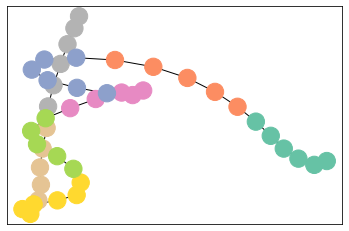

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
# 画图函数
def visualize_graph(G, color):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
# 使用networkx进行可视化展示
G = to_networkx(train_dataset3[0], to_undirected=True)
visualize_graph(G, color=train_dataset3[0].y)

### 17.4.5 构造图网络

图数据构造结束之后，接下来，我们构造图网络，采用PyTorch Geometric的GCNConv层以及PyTorch的LSTM层去构建

In [39]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch  # 导入torch模块，用于张量操作和构造数据集

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(520)
        self.lstm1 = nn.LSTM(18, 100, 2)  # LSTM层1，输入维度为18，隐藏状态维度为100，LSTM层数为2
        self.norm1 = nn.BatchNorm1d(100)  # 批标准化层1
        self.gcnconv = GCNConv(100, 50)  # GCNConv层，输入特征维度为100，输出特征维度为50
        self.norm2 = nn.BatchNorm1d(50)  # 批标准化层2
        self.lstm2 = nn.LSTM(50, 25, 2)  # LSTM层2，输入维度为50，隐藏状态维度为25，LSTM层数为2
        self.norm3 = nn.BatchNorm1d(25)  # 批标准化层3
        self.layer3 = nn.Linear(25, 1)   # 线性层，输入维度为25，输出维度为1

    def forward(self, x, edge_index):
        a,c = x.shape              # 获取输入数据x的形状信息
        x, _ = self.lstm1(x.view(-1, 1, c)) # 应用批标准化层和ReLU激活函数
        x = self.norm1(x.view(-1, x.size(-1)))
        x = F.relu(x)
        h = self.gcnconv(x, edge_index) # 将特征向量x输入到GCNConv层中
        h = self.norm2(h)  # 应用批标准化层和ReLU激活函数
        h = F.relu(h)
        x, _ = self.lstm2(h.view(-1, 1, h.size(-1)))  # 经过LSTM层2处理
        x = self.norm3(x.view(-1, x.size(-1))) # 应用批标准化层和ReLU激活函数
        x = F.relu(x)
        out = torch.sigmoid(self.layer3(x)) # 将特征向量x输入到线性层中，并应用Sigmoid激活函数得到输出结果
        return out, h

### 17.4.6 模型训练与预测

图数据构造结束之后，接下来，我们将利用图网络进行数据分析和预测。通过对图网络的深入挖掘，我们可以发现数据中的异常模式和趋势，进而利用图网络进行寿命预测，代码如下：

In [40]:
from torch_geometric.data import Data  # 导入Data模块，用于构造图数据
from scipy.io import loadmat  # 导入loadmat函数，用于加载.mat文件
import torch  # 导入torch模块，用于张量操作和构造数据集
import numpy as np  # 导入numpy模块，用于构造数据集
from scipy.spatial.distance import pdist # 计算数据集各个点之间的欧几里得距离
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
def Path_attr(data):
    '''
    定义函数 Path_attr，用于计算路径属性。
    参数：data：输入数据
    返回值：edge_index：边索引
    w：权重
    '''
    # 初始化边索引
    edge_index = [[], []]
    # 构建边索引
    for i in range(len(data) - 1):
        edge_index[0].append(i)
        edge_index[1].append(i + 1)
    # 计算相邻节点之间的欧氏距离
    distance = []
    for j in range(len(data) - 1):
        v_1 = data[j]
        v_2 = data[j + 1]
        combine = np.vstack([v_1, v_2])
        likely = pdist(combine, 'euclidean')
        distance.append(likely[0])
    # 计算高斯核权重
    beata = np.mean(distance)
    w = np.exp((-(np.array(distance)) ** 2) / (2 * (beata ** 2)))  #Gussion kernel高斯核
    return edge_index, w


def data_graph(dir):
    """
    构造图数据
    :param dir: 路径
    :return: train1_dataset, train2_dataset, train3_dataset, train4_dataset, test_dataset
    """
    # 加载训练数据1
    m1 = loadmat(dir + "负载4000_1_5.mat")
    train_s1 = m1["feature_RUL_time"]
    train_x1 = train_s1[:, 0:18]  # 左闭右开
    train_y1 = train_s1[:, 18]

    # 加载训练数据2
    m2 = loadmat(dir + "负载4000_4_5.mat")
    train_s2 = m2["feature_RUL_time"]
    train_x2 = train_s2[:, 0:18]  # 左闭右开
    train_y2 = train_s2[:, 18]

    # 加载训练数据3
    m3 = loadmat(dir + "负载4000_5_5.mat")
    train_s3 = m3["feature_RUL_time"]
    train_x3 = train_s3[:, 0:18]  # 左闭右开
    train_y3 = train_s3[:, 18]

    # 加载训练数据4
    m4 = loadmat(dir + "负载4000_7_5.mat")
    train_s4 = m4["feature_RUL_time"]
    train_x4 = train_s4[:, 0:18]  # 左闭右开
    train_y4 = train_s4[:, 18]

    # 加载测试数据
    m7 = loadmat(dir + "负载4000_3_5.mat")
    test_s1 = m7["feature_RUL_time"]
    test_x1 = test_s1[:, 0:18]  # 左闭右开
    test_y1 = test_s1[:, 18]

    edge_index1, edge_fea1 = Path_attr(train_x1)
    edge_index2, edge_fea2 = Path_attr(train_x2)
    edge_index3, edge_fea3 = Path_attr(train_x3)
    edge_index4, edge_fea4 = Path_attr(train_x4)
    edge_index7, edge_fea7 = Path_attr(test_x1)

    # 将ndarray数据转换为张量，因为pytorch用的数据类型是张量
    train_x1 = torch.from_numpy(train_x1).type(torch.FloatTensor)
    train_y1 = torch.from_numpy(train_y1).type(torch.FloatTensor)

    train_x2 = torch.from_numpy(train_x2).type(torch.FloatTensor)
    train_y2 = torch.from_numpy(train_y2).type(torch.FloatTensor)

    train_x3 = torch.from_numpy(train_x3).type(torch.FloatTensor)
    train_y3 = torch.from_numpy(train_y3).type(torch.FloatTensor)

    train_x4 = torch.from_numpy(train_x4).type(torch.FloatTensor)
    train_y4 = torch.from_numpy(train_y4).type(torch.FloatTensor)

    test_x1 = torch.from_numpy(test_x1).type(torch.FloatTensor)
    test_y1 = torch.from_numpy(test_y1).type(torch.FloatTensor)

    train1_dataset = []
    edge_index = torch.tensor(edge_index1, dtype=torch.long)
    train_data = Data(x=train_x1, y=train_y1, edge_index=edge_index)
    train1_dataset.append(train_data)

    train2_dataset = []
    edge_index = torch.tensor(edge_index2, dtype=torch.long)
    train_data = Data(x=train_x2, y=train_y2, edge_index=edge_index)
    train2_dataset.append(train_data)

    train3_dataset = []
    edge_index = torch.tensor(edge_index3, dtype=torch.long)
    train_data = Data(x=train_x3, y=train_y3, edge_index=edge_index)
    train3_dataset.append(train_data)

    train4_dataset = []
    edge_index = torch.tensor(edge_index4, dtype=torch.long)
    train_data = Data(x=train_x4, y=train_y4, edge_index=edge_index)
    train4_dataset.append(train_data)

    test_dataset = []
    edge_index = torch.tensor(edge_index7, dtype=torch.long)
    test_data = Data(x=test_x1, y=test_y1, edge_index=edge_index)
    test_dataset.append(test_data)

    return train1_dataset, train2_dataset, train3_dataset, train4_dataset, test_dataset  # 返回训练集和测试集

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(520)
        self.lstm1 = nn.LSTM(18, 100, 2)  # LSTM层1，输入维度为18，隐藏状态维度为100，LSTM层数为2
        self.norm1 = nn.BatchNorm1d(100)  # 批标准化层1
        self.gcnconv = GCNConv(100, 50)  # GCNConv层，输入特征维度为100，输出特征维度为50
        self.norm2 = nn.BatchNorm1d(50)  # 批标准化层2
        self.lstm2 = nn.LSTM(50, 25, 2)  # LSTM层2，输入维度为50，隐藏状态维度为25，LSTM层数为2
        self.norm3 = nn.BatchNorm1d(25)  # 批标准化层3
        self.layer3 = nn.Linear(25, 1)   # 线性层，输入维度为25，输出维度为1

    def forward(self, x, edge_index):
        a,c = x.shape              # 获取输入数据x的形状信息
        x, _ = self.lstm1(x.view(-1, 1, c)) # 应用批标准化层和ReLU激活函数
        x = self.norm1(x.view(-1, x.size(-1)))
        x = F.relu(x)
        h = self.gcnconv(x, edge_index) # 将特征向量x输入到GCNConv层中
        h = self.norm2(h)  # 应用批标准化层和ReLU激活函数
        h = F.relu(h)
        x, _ = self.lstm2(h.view(-1, 1, h.size(-1)))  # 经过LSTM层2处理
        x = self.norm3(x.view(-1, x.size(-1))) # 应用批标准化层和ReLU激活函数
        x = F.relu(x)
        out = torch.sigmoid(self.layer3(x)) # 将特征向量x输入到线性层中，并应用Sigmoid激活函数得到输出结果
        return out, h

def train(train_dataset):
    """
    训练模型
    :param train_dataset: 训练数据集
    :return: loss
    """
    model.train() # 设置模型为训练模式
    for data in train_dataset:
        data = data.to(device)  # 将数据移动到指定设备（如GPU）
        optimizer.zero_grad() # 清零优化器的梯度
        out, h =model(data.x, data.edge_index) # 运行模型获取输出
        loss = criterion(out, data.y.unsqueeze(1)) # 计算损失
        loss.backward()   # 反向传播计算梯度
        optimizer.step()  # 根据梯度更新模型参数
    return loss
# 两个评价指标
def rmse(predictions, targets):
    """
    计算均方根误差(Root Mean Squared Error, RMSE)
    :param predictions: 预测值
    :param targets: 实际值
    :return: 返回RMSE值
    """
    return np.sqrt(((predictions - targets) ** 2).mean())

def mae(predictions, targets):
    """
    计算平均绝对误差(Mean Absolute Error, MAE)
    :param predictions: 预测值
    :param targets: 实际值
    :return: 返回MAE值
    """
    return np.sum(np.absolute(predictions - targets)) / len(predictions)

def evaluate(test_dataset):
    """
    评估模型
    :param test_dataset: 测试数据集
    :return: pred_rmse,pred_mae
    """
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 禁用梯度计算
        for test_data in test_dataset:
            test_data = test_data.to(device)  # 将数据移动到指定设备（如GPU）
            pred, h = model(test_data.x, test_data.edge_index) # 获取模型输出
            pred_test = pred.view(-1).data.cpu().numpy()  # 获取预测值
            pred_rmse = rmse(pred_test, test_data.y.cpu().numpy()) # 计算rmse
            pred_mae = mae(pred_test, test_data.y.cpu().numpy()) # 计算mae
    return pred_rmse,pred_mae

if __name__ == '__main__':
    # 获取数据集
    dir = r".\PHM2012\带标签特征\\"
    train_dataset1,train_dataset2,train_dataset3,train_dataset4,test_dataset = data_graph(dir)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设置设备（GPU或CPU）
    model = GCN().to(device)
    # 损失函数
    criterion = torch.nn.SmoothL1Loss()
    # 定义优化器和初始学习率
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
    # 3.迭代训练
    for epoch in range(50):  # 迭代训练
        loss = train(train_dataset1)  # 训练模型并获取xunlian损失值
        if epoch % 10 == 0:  # 每10个epoch输出一次训练信息
            pred_rmse, pred_mae = evaluate(test_dataset)  # 测试模型并获取rmse,mae
            print("Epoch:%d|train loss:%.4f|test_rmse:%.4f|test_mae:%.4f" % (epoch, loss.item(), pred_rmse, pred_mae))  # 输出结果信息

Epoch:0|train loss:0.0440|test_rmse:0.2893|test_mae:0.2505
Epoch:10|train loss:0.0115|test_rmse:0.2896|test_mae:0.2506
Epoch:20|train loss:0.0036|test_rmse:0.2905|test_mae:0.2510
Epoch:30|train loss:0.0021|test_rmse:0.2911|test_mae:0.2511
Epoch:40|train loss:0.0013|test_rmse:0.2873|test_mae:0.2478



## 参考资料

[PYG官方文档](https://pytorch-geometric.readthedocs.io/en/latest/ "最好的PYG教程网站")

[凯斯西储轴承数据集解读与整理](https://zhuanlan.zhihu.com/p/448210993)

Li T, Zhou Z, Li S, et al. The emerging graph neural networks for intelligent fault diagnostics and prognostics: A guideline and a benchmark study[J]. Mechanical Systems and Signal Processing, 2022, 168: 108653.